In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

sys.path.append('../tools')
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
from torch import nn
from tqdm import tqdm
import sklearn

import torchvision.transforms as T
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks

import kaggle_data_utility
from models.kaggle_dog_dataloader import KaggleDataset

In [3]:
data_dir = "../../../user_data/competition_data/clips"
log_folder_root = '../../../user_data/logs/'
ckpt_folder_root = '../../../user_data/checkpoints/'

targets = [
    'Dog_1',
    'Dog_2',
    'Dog_3',
    'Dog_4',
]

# targets = [
#     'Patient_1',
#     'Patient_2',
#     'Patient_3',
#     'Patient_4',
#     'Patient_5',
#     'Patient_6',
#     'Patient_7',
#     'Patient_8'
# ]

In [4]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
determine_generator = torch.Generator()
determine_generator.manual_seed(random_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    # True ensures the algorithm selected by CUFA is deterministic
    torch.backends.cudnn.deterministic = True
    # torch.set_deterministic(True)
    # False ensures CUDA select the same algorithm each time the application is run
    torch.backends.cudnn.benchmark = False

In [5]:
def read_pickle(path, num):
    data_list = []
    for i in range(num):
        clip = pd.read_pickle(path + str(i) + '.pkl')
        data_list.append(clip)
    return data_list

seizure_time = read_pickle('../../../user_data/ieeg/seizure_time/seizure_time_data', 150)

FileNotFoundError: [Errno 2] No such file or directory: '../../../user_data/ieeg/seizure_time/seizure_time_data0.pkl'

In [ ]:
fs  = []
for st in seizure_time:
    fs.append(1/(st[1]-st[0]))

In [ ]:
fs

In [8]:
ictal_data_list = [kaggle_data_utility.parse_input_data(data_dir, targets[i], 'ictal', None) for i in
                   range(len(targets))]
interictal_data_list = [kaggle_data_utility.parse_input_data(data_dir, targets[i], 'interictal', None) for i in
                        range(len(targets))]
test_data_list = [kaggle_data_utility.parse_input_data(data_dir, targets[i], 'test', None) for i in range(len(targets))]

Loading data
(0s)
X (178, 16, 400) y (178,) latencies (178,)
Loading data
(0s)
X (172, 16, 400) y (172,) latencies (172,)
Loading data
(1s)
X (480, 16, 400) y (480,) latencies (480,)
Loading data
(1s)
X (257, 16, 400) y (257,) latencies (257,)
Loading data
(1s)
X (418, 16, 400) y (418,)
Loading data
(4s)
X (1148, 16, 400) y (1148,)
Loading data
(18s)
X (4760, 16, 400) y (4760,)
Loading data
(10s)
X (2790, 16, 400) y (2790,)
Loading data
(12s)
X (3181, 16, 400)
Loading data
(11s)
X (2997, 16, 400)
Loading data
(16s)
X (4450, 16, 400)
Loading data
(11s)
X (3013, 16, 400)


In [8]:
# ictal_data_X = np.empty((0, 16, 400))
# interictal_data_X = np.empty((0, 16, 400))
# test_data_X = np.empty((0, 16, 400))
#
# for data in ictal_data_list:
#     ictal_data_X = np.vstack((ictal_data_X, data['X']))
# for data in interictal_data_list:
#     interictal_data_X = np.vstack((interictal_data_X, data['X']))
# for data in test_data_list:
#     test_data_X = np.vstack((test_data_X, data['X']))

In [9]:
data_X = np.empty((0, 16, 400))
test_data_X = np.empty((0, 16, 400))
data_y = np.empty((0, 1))
for i in tqdm(range(len(ictal_data_list))):
    ictal_data = ictal_data_list[i]['X']
    interictal_data = interictal_data_list[i]['X']
    test_data = test_data_list[i]['X']
    ictal_label = ictal_data_list[i]['y']
    interictal_label = interictal_data_list[i]['y']

    data = np.concatenate((ictal_data, interictal_data))
    label = np.concatenate((ictal_label, interictal_label))

    data_X = np.vstack((data_X, data))
    test_data_X = np.vstack((test_data_X, test_data))
    data_y = np.vstack((data_y, label[:, np.newaxis]))


100%|██████████| 4/4 [00:00<00:00,  8.16it/s]


In [10]:
data_y

array([[0.],
       [0.],
       [0.],
       ...,
       [2.],
       [2.],
       [2.]])

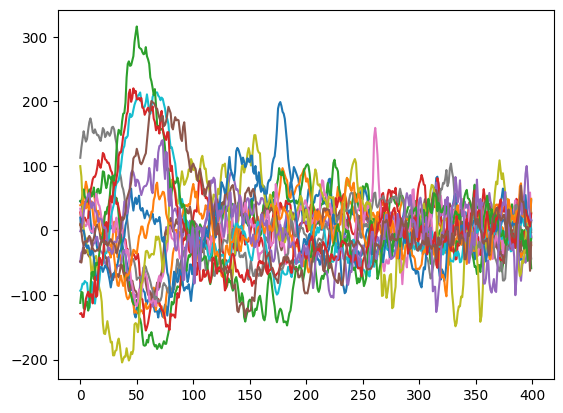

In [11]:
from matplotlib import pyplot as plt

plt.plot(data_X[0].T)
plt.show()

In [28]:
def plot_data(data, labels = None, dr=200, id = None):
    color_list = ["#FFBE7A", '#2878b5']
    label_list = ["early_onset", "ictal", "inter-ictal"]
    n_samples, n_rows = data.shape[1], data.shape[0]
    h, w = n_rows * 2, 10
    y_tick_offsets = (np.arange(n_rows) * dr)[::-1] 
    plt.figure(figsize=(8, 5))
    ax = plt.axes()
    eeg_data = data + y_tick_offsets[:, np.newaxis]
    time_domain = np.repeat(np.linspace(0,1000,400)[:,np.newaxis],16,1)
    plt.plot(time_domain, eeg_data.T, 'k', linewidth=0.5)
    # for j, label in enumerate(labels):
    #     if label is not None:
    #         label_start, label_end= plot_high_light(label)
    #         if len(label_start)>0:
    #             for i in range(len(label_start)):
    #                 # print(label_start,label_end)
    #                 plt.axvspan(label_start[i], label_end[i], color=color_list[j], alpha=0.3)
    
    plt.yticks(eeg_data.mean(1),fontsize=11)
    ax.set_yticklabels([f"Ch{i}" for i in range(1, 16 + 1)])
    
    # Set the number of x-ticks to 8
    num_ticks = 9
    x_ticks_positions = np.linspace(0, time_domain.max(), num_ticks)
    
    ax.set_xticks(x_ticks_positions)  # Set positions

    plt.grid(axis='x')
    # legend_elements = [Patch(facecolor='#FFBE7A', edgecolor='#FFBE7A', label='Annotation'),
    #                Patch(facecolor='#2878b5', edgecolor='#2878b5', label='Prediction')]
    
    # plt.legend(handles=legend_elements, loc = 'upper right',fontsize=11)
    
    # plt.legend(legend_elements, labels, handler_map={tuple: HandlerTuple(ndivide=None)}, loc='upper right')
    # Additional plot formatting
    plt.xlabel('Time (ms)', fontsize=13)
    plt.ylim(y_tick_offsets[-1]-dr*2, y_tick_offsets[0]+dr*2)
    plt.title(str(id)+', '+str(label_list[int(labels[id])]))
    
    plt.savefig("dog_neuro_vista_example/" + str(label_list[int(labels[id])]) +"/dog_neuro_vista_" + str(id) + ".svg", format="svg")
    # Show plot
    # plt.show()
    # print(y_tick_offsets[0]-dr,y_tick_offsets[-1]+dr)

    plt.show()

In [20]:
np.repeat(np.linspace(0,1000,400)[:,np.newaxis],16,1)

array([[   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   2.50626566,    2.50626566,    2.50626566, ...,    2.50626566,
           2.50626566,    2.50626566],
       [   5.01253133,    5.01253133,    5.01253133, ...,    5.01253133,
           5.01253133,    5.01253133],
       ...,
       [ 994.98746867,  994.98746867,  994.98746867, ...,  994.98746867,
         994.98746867,  994.98746867],
       [ 997.49373434,  997.49373434,  997.49373434, ...,  997.49373434,
         997.49373434,  997.49373434],
       [1000.        , 1000.        , 1000.        , ..., 1000.        ,
        1000.        , 1000.        ]])

In [23]:
import matplotlib
matplotlib.use('cairo')
from tqdm import tqdm
for id in tqdm(range(len(data_y))):
    plot_data(data_X[id], labels = data_y, id=id)

  0%|          | 20/10203 [00:00<05:39, 30.02it/s]C:\Users\sirrus\AppData\Local\Temp\ipykernel_27472\2890653031.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 5))
  5%|▍         | 477/10203 [00:18<06:10, 26.24it/s]

KeyboardInterrupt



In [29]:
id = 0
plot_data(data_X[id], labels = data_y, id=id)

C:\Users\sirrus\AppData\Local\Temp\ipykernel_27472\2775382348.py:46: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [51]:
unlabeled_dataset = KaggleDataset(data_X, data_y, test_data_X, labeled=False, transform=True, astensor=False)
# train_set_size = int(unlabeled_dataset.length * 0.8)
# valid_set_size = unlabeled_dataset.length - train_set_size
# train_set, test_set = torch.utils.data.random_split(unlabeled_dataset, [train_set_size, valid_set_size],generator=determine_generator)

In [10]:
unlabeled_dataset.length

23844

In [11]:
# import torch
# import torchvision
# from torch import nn
#
# from lightly.data import LightlyDataset, SwaVCollateFunction
# from lightly.loss import SwaVLoss
# from lightly.loss.memory_bank import MemoryBankModule
# from lightly.models.modules import SwaVProjectionHead, SwaVPrototypes
#
#
# class SwaV(nn.Module):
#     def __init__(self, backbone):
#         super().__init__()
#         self.backbone = backbone
#         self.projection_head = SwaVProjectionHead(512, 512, 128)
#         self.prototypes = SwaVPrototypes(128, 512, 5)
#
#         self.start_queue_at_epoch = 30
#         self.queues = nn.ModuleList([MemoryBankModule(size=512) for _ in range(2)])
#
#     def forward(self, high_resolution, low_resolution, epoch):
#         self.prototypes.normalize()
#
#         high_resolution_features = [self._subforward(x) for x in high_resolution]
#         low_resolution_features = [self._subforward(x) for x in low_resolution]
#
#         high_resolution_prototypes = [
#             self.prototypes(x, epoch) for x in high_resolution_features
#         ]
#         low_resolution_prototypes = [
#             self.prototypes(x, epoch) for x in low_resolution_features
#         ]
#         queue_prototypes = self._get_queue_prototypes(high_resolution_features, epoch)
#
#         return high_resolution_prototypes, low_resolution_prototypes, queue_prototypes
#
#     def _subforward(self, input):
#         features = self.backbone(input).flatten(start_dim=1)
#         features = self.projection_head(features)
#         features = nn.functional.normalize(features, dim=1, p=2)
#         return features
#
#     @torch.no_grad()
#     def _get_queue_prototypes(self, high_resolution_features, epoch):
#         if len(high_resolution_features) != len(self.queues):
#             raise ValueError(
#                 f"The number of queues ({len(self.queues)}) should be equal to the number of high "
#                 f"resolution inputs ({len(high_resolution_features)}). Set `n_queues` accordingly."
#             )
#
#         # Get the queue features
#         queue_features = []
#         for i in range(len(self.queues)):
#             _, features = self.queues[i](high_resolution_features[i], update=True)
#             # Queue features are in (num_ftrs X queue_length) shape, while the high res
#             # features are in (batch_size X num_ftrs). Swap the axes for interoperability.
#             features = torch.permute(features, (1, 0))
#             queue_features.append(features)
#
#         # If loss calculation with queue prototypes starts at a later epoch,
#         # just queue the features and return None instead of queue prototypes.
#         if self.start_queue_at_epoch > 0 and epoch < self.start_queue_at_epoch:
#             return None
#
#         # Assign prototypes
#         queue_prototypes = [self.prototypes(x, epoch) for x in queue_features]
#         return queue_prototypes
#
#
# resnet = torchvision.models.resnet34()
#
# backbone = nn.Sequential(*list(resnet.children())[:-1])
# model = SwaV(backbone)
#
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

# collate_fn = SwaVCollateFunction(gaussian_blur = 0, hf_prob = 0,vf_prob = 0,rr_prob=0,cj_prob=0,random_gray_scale=0, normalize={'mean':[0, 0, 0], 'std':[1, 1, 1]})
#
# dataloader = torch.utils.data.DataLoader(
#     unlabeled_dataset,
#     batch_size=128,
#     collate_fn=collate_fn,
#     shuffle=True,
#     drop_last=True,
# )
#
# criterion = SwaVLoss(sinkhorn_epsilon = 0.05)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#
# # torch.save({
# #             'epoch': -1,
# #             'model_state_dict': model.state_dict(),
# #             'optimizer_state_dict': optimizer.state_dict(),
# #             'loss': -1,
# #             }, 'ckpt/checkpoint_round_2'+str(-1)+'.pth')
#
# print("Starting Training")
# for epoch in range(100):
#     total_loss = 0
#     i = 0 
#     for batch, _, _ in tqdm(dataloader):
#         batch = [x.to(device) for x in batch]
#         high_resolution, low_resolution = batch[:2], batch[2:]
#         high_resolution, low_resolution, queue = model(
#             high_resolution, low_resolution, epoch
#         )
#         loss = criterion(high_resolution, low_resolution, queue)
#         total_loss += loss.detach()
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#
#     avg_loss = total_loss / len(dataloader)
#     torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': avg_loss,
#             }, 'kaggle_human_ckpt/checkpoint'+str(epoch)+'.pth')
#
#     print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

In [12]:
from models.SwaV import SwaV
from models.SupervisedDownstream import SupervisedDownstream
from lightly.data import SwaVCollateFunction
#
# model = SwaV()
#
# # model.load_from_checkpoint()
#
# collate_fn = SwaVCollateFunction(gaussian_blur = 0, hf_prob = 0,vf_prob = 0,rr_prob=0,cj_prob=0,random_gray_scale=0, normalize={'mean':[0, 0, 0], 'std':[1, 1, 1]})
#
# dataloader = torch.utils.data.DataLoader(
#     unlabeled_dataset,
#     batch_size=64,
#     collate_fn=collate_fn,
#     shuffle=True,
#     drop_last=True,
# )
# accelerator = "gpu" if torch.cuda.is_available() else "cpu"
#
# checkpoint_callback = pl_callbacks.ModelCheckpoint(monitor='swav_loss',filename='kaggle_dog_swav-{epoch:02d}-{swav_loss:.5f}', save_last=True, save_top_k=-1, dirpath=ckpt_folder_root + 'kaggle_dog_swav_50')
# csv_logger = pl_loggers.CSVLogger(log_folder_root, name="kaggle_dog_swav")
#
# trainer = pl.Trainer(logger=csv_logger, max_epochs=120, callbacks=[checkpoint_callback],accelerator='gpu', devices=1)

In [13]:
# trainer.fit(model=model, train_dataloaders=dataloader,ckpt_path=ckpt_folder_root+'kaggle_dog_swav_50/kaggle_dog_swav-epoch=34-swav_loss=4.00448.ckpt')



In [14]:
# unlabeled_dataset = KaggleDataset(ictal_data_X, interictal_data_X, test_data_X, labeled=False, transform=True)
# train_set_size = int(labeled_dataset.length * 0.8)
# valid_set_size = labeled_dataset.length - train_set_size
# train_set, test_set = torch.utils.data.random_split(labeled_dataset, [train_set_size, valid_set_size])

In [15]:
# swav = SwaV().load_from_checkpoint(ckpt_folder_root + 'kaggle_dog_swav_18/kaggle_dog_swav-epoch=116-swav_loss=2.23095.ckpt')
swav = SwaV().load_from_checkpoint(
    ckpt_folder_root + 'kaggle_dog_swav_34/kaggle_dog_swav-epoch=116-swav_loss=2.73583.ckpt')
# swav = SwaV().load_from_checkpoint(ckpt_folder_root + 'kaggle_dog_swav_50/kaggle_dog_swav-epoch=118-swav_loss=3.64062.ckpt')
model = SupervisedDownstream(swav.backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

checkpoint_callback = pl_callbacks.ModelCheckpoint(monitor='val_loss',
                                                   filename='kaggle_dog_linear_eval-{epoch:02d}-{val_loss:.5f}',
                                                   save_last=True, save_top_k=-1,
                                                   dirpath=ckpt_folder_root + 'kaggle_dog_swav_34_linear_eval_3c')
csv_logger = pl_loggers.CSVLogger(log_folder_root, name="kaggle_dog_swav_34_linear_eval_3c")

trainer = pl.Trainer(logger=csv_logger, max_epochs=80, callbacks=[checkpoint_callback], accelerator='gpu', devices=1)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:

labeled_dataset = KaggleDataset(data_X, data_y, test_data_X, labeled=True, transform=True)
train_set_size = int(labeled_dataset.length * 0.8)
valid_set_size = labeled_dataset.length - train_set_size
train_set, test_set = torch.utils.data.random_split(labeled_dataset, [train_set_size, valid_set_size],
                                                    generator=torch.Generator().manual_seed(42))


def collate_fn(batch):
    info = list(zip(*batch))
    data = info[0]
    label = info[1]
    return torch.stack(data), torch.stack(label)


train_dataloader = torch.utils.data.DataLoader(
    train_set,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)
val_dataloader = torch.utils.data.DataLoader(
    test_set,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True,
)
trainer.fit(model, train_dataloader, val_dataloader)

C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:616: UserWarning: Checkpoint directory C:\Users\Patrick Xu\Desktop\RNS_Annotation-Pipeline\user_data\checkpoints\kaggle_dog_swav_34_linear_eval_3c exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | backbone | Sequential | 21.3 M
1 | fc1      | Linear     | 131 K 
2 | fc2      | Linear     | 16.4 K
3 | fc3      | Linear     | 520   
4 | fc4      | Linear     | 27    
5 | softmax  | Softmax    | 0     
----------------------------------------
21.4 M    Trainable params
0         Non-trainable params
21.4 M    Total params
85.732    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\trainer.py:1892: PossibleUserWarning: Th

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [30]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)

print(input)
print(target)

tensor([[-1.4234,  1.4006, -0.0382,  0.3646, -1.9584],
        [-0.6761, -0.5008, -1.2458, -0.4481, -0.1537],
        [-1.9868, -0.0352, -1.0558, -0.3352, -0.5795]], requires_grad=True)
tensor([3, 2, 2])


In [17]:
labeled_dataset = KaggleDataset(data_X, data_y, test_data_X, labeled=True, transform=False)
train_set_size = int(labeled_dataset.length * 0.8)
valid_set_size = labeled_dataset.length - train_set_size
train_set, test_set = torch.utils.data.random_split(labeled_dataset, [train_set_size, valid_set_size],
                                                    generator=torch.Generator().manual_seed(42))
train_dataloader = torch.utils.data.DataLoader(
    train_set,
    batch_size=128,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)
val_dataloader = torch.utils.data.DataLoader(
    test_set,
    batch_size=128,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True,
)
predictions = trainer.predict(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 3it [00:00, ?it/s]

In [42]:
train_set

In [18]:
output_list = []
target_list = []
emb_list = []
m = nn.Softmax(dim=1)
for pred, y, emb in predictions:
    output_list.append(pred)
    target_list.append(y)
    emb_list.append(emb)

In [19]:
pred_raw = torch.vstack(output_list)
target = torch.vstack(target_list)
emb = torch.vstack(emb_list)
out = torch.argmax(pred_raw, dim=1)

In [ ]:
def translate_prediction(prediction, y_classes):
    if len(prediction) == 3:
        # S is 1.0 when ictal <=15 or >15
        # S is 0.0 when interictal is highest
        ictalLTE15, ictalGT15, interictal = prediction
        S = ictalLTE15 + ictalGT15
        E = ictalLTE15
        return S, E
    elif len(prediction) == 2:
        # 1.0 doesn't exist for Patient_4, i.e. there is no late seizure data
        if not np.any(y_classes == 1.0):
            ictalLTE15, interictal = prediction
            S = ictalLTE15
            E = ictalLTE15
            # y[i] = 0 # ictal <= 15
            # y[i] = 1 # ictal > 15
            # y[i] = 2 # interictal
            return S, E
        else:
            raise NotImplementedError()
    else:
        raise NotImplementedError()


# use the classifier and make predictions on the test data
def make_predictions(target, X_test, y_classes, classifier_data):
    classifier = classifier_data.classifier
    predictions_proba = classifier.predict_proba(X_test)

    lines = []
    for i in range(len(predictions_proba)):
        p = predictions_proba[i]
        S, E = translate_prediction(p, y_classes)
        lines.append('%s_test_segment_%d.mat,%.15f,%.15f' % (target, i+1, S, E))

    return {
        'data': '\n'.join(lines)
    }


# the scoring mechanism used by the competition leaderboard
def score_classifier_auc(classifier, X_cv, y_cv, y_classes):
    predictions = classifier.predict_proba(X_cv)
    S_predictions = []
    E_predictions = []
    S_y_cv = [1.0 if (x == 0.0 or x == 1.0) else 0.0 for x in y_cv]
    E_y_cv = [1.0 if x == 0.0 else 0.0 for x in y_cv]

    for i in range(len(predictions)):
        p = predictions[i]
        S, E = translate_prediction(p, y_classes)
        S_predictions.append(S)
        E_predictions.append(E)

    fpr, tpr, thresholds = roc_curve(S_y_cv, S_predictions)
    S_roc_auc = auc(fpr, tpr)
    fpr, tpr, thresholds = roc_curve(E_y_cv, E_predictions)
    E_roc_auc = auc(fpr, tpr)

    return S_roc_auc, E_roc_auc

In [73]:
E_roc_auc

0.9307147306135161

In [61]:
output = torch.vstack(output_list)
target = torch.vstack(target_list)
inds = np.where(target == 0)

S = output[:,0] + output[:,1]
E = output[:,0]
S_y_cv = [1.0 if (x == 0.0 or x == 1.0) else 0.0 for x in target]
E_y_cv = [1.0 if x == 0.0 else 0.0 for x in target]

fpr, tpr, thresholds = sklearn.metrics.roc_curve(S_y_cv, S, pos_label=1)
S_roc_auc = sklearn.metrics.auc(fpr, tpr)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(E_y_cv, E, pos_label=1)
E_roc_auc = sklearn.metrics.auc(fpr, tpr)

In [62]:
(S_roc_auc+E_roc_auc)/2

0.9581157137109456

In [48]:
np.argmax(output,axis=1)

tensor([2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2,
        2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1,

In [40]:
len(torch.sort(m(output)[:, 0][inds])[0])

65

In [28]:
sklearn.metrics.accuracy_score(np.argmax(m(output), axis=1), target)

0.9583537481626654

In [30]:
clf_report = sklearn.metrics.classification_report(np.argmax(m(output), axis=1), target, digits=6)

print(f"Classification Report : \n{clf_report}")

Classification Report : 
              precision    recall  f1-score   support

           0   0.000000  0.000000  0.000000         0
           1   0.953333  0.684211  0.796657       209
           2   0.992881  0.989629  0.991252      1832

    accuracy                       0.958354      2041
   macro avg   0.648738  0.557946  0.595970      2041
weighted avg   0.988831  0.958354  0.971325      2041


C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [40]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [41]:
pca_comp_n = 30
batch_size = 32

pca = PCA(n_components=pca_comp_n, copy=True).fit(emb)
p = pca.transform(emb)

# ind = np.random.choice(len(emb), 10000)
#
tsne = TSNE(n_components=2, verbose=1, perplexity=75, random_state=142, init='pca')
z = tsne.fit_transform(emb)
interictal_inds = np.where(target == 0)[0]
ictal_inds = np.where(target == 1)[0]


C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 226 nearest neighbors...
[t-SNE] Indexed 2041 samples in 0.001s...
[t-SNE] Computed neighbors for 2041 samples in 0.129s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2041
[t-SNE] Computed conditional probabilities for sample 2000 / 2041
[t-SNE] Computed conditional probabilities for sample 2041 / 2041
[t-SNE] Mean sigma: 2.782243
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.894039
[t-SNE] KL divergence after 1000 iterations: 0.446441


TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

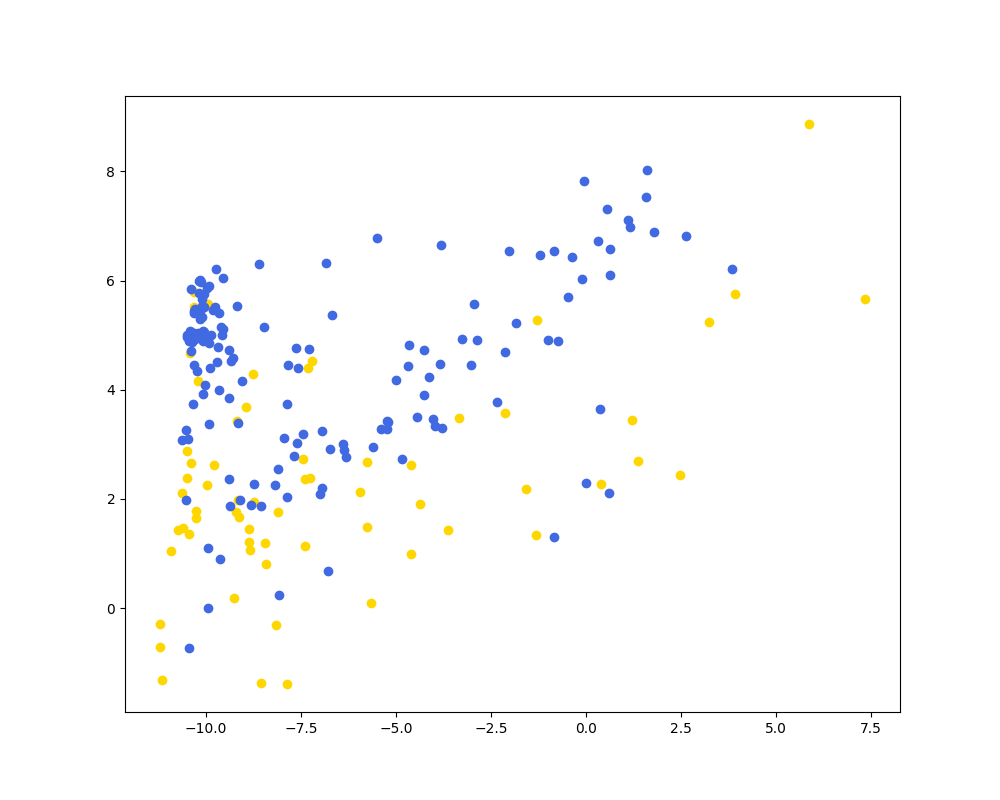

In [43]:
spc = p
plt.figure(figsize=(10, 8))
plt.scatter(spc[interictal_inds, 0], spc[interictal_inds, 1], c='gold', label='interictal')
plt.scatter(spc[ictal_inds, 0], spc[ictal_inds, 1], c='royalblue', label='ictal')
plt.scatter()
# plt.title('Swav Embedding t-SNE')
plt.xlabel('comp 1')
plt.ylabel("comp 2")
plt.legend()
# plt.xlim(-67, 74)
# plt.ylim(-67, 75)
plt.grid()
plt.show()

In [50]:
from sklearn.metrics import RocCurveDisplay
target, np.argmax(output,axis=1)

RocCurveDisplay.from_predictions(
    target,
    np.argmax(output,axis=1),
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

ValueError: multiclass format is not supported

In [ ]:
output[:, 1]

In [ ]:

output = torch.argmax(output, dim=1)
output = output.detach().cpu().numpy()
target = target.squeeze().detach().cpu().numpy()

In [ ]:
import sklearn

clf_report = sklearn.metrics.classification_report(output, target, digits=6)

print(f"Classification Report : \n{clf_report}")

In [ ]:
for batch, label in tqdm(val_dataloader):
    batch = batch.to(device)
    label = label.to(device)
    label = F.one_hot(label).squeeze()
    outputs = model(batch)
    print(batch)
    loss = sigmoid_focal_loss(pred.float(), label.float(), alpha=0.5, gamma=8, reduction='mean')
    print(loss)
    break

In [ ]:
# import copy
# import torch
# import torchvision
# from torch import nn
#
# from lightly.data import DINOCollateFunction, LightlyDataset
# from lightly.loss import DINOLoss
# from lightly.models.modules import DINOProjectionHead
# from lightly.models.utils import deactivate_requires_grad, update_momentum
# from lightly.utils.scheduler import cosine_schedule
#
#
# class DINO(torch.nn.Module):
#     def __init__(self, backbone, input_dim):
#         super().__init__()
#         self.student_backbone = backbone
#         self.student_head = DINOProjectionHead(
#             input_dim, 512, 64, 2048, freeze_last_layer=1
#         )
#         self.teacher_backbone = copy.deepcopy(backbone)
#         self.teacher_head = DINOProjectionHead(input_dim, 512, 64, 2048)
#         deactivate_requires_grad(self.teacher_backbone)
#         deactivate_requires_grad(self.teacher_head)
#
#     def forward(self, x):
#         y = self.student_backbone(x).flatten(start_dim=1)
#         z = self.student_head(y)
#         return z
#
#     def forward_teacher(self, x):
#         y = self.teacher_backbone(x).flatten(start_dim=1)
#         z = self.teacher_head(y)
#         return z
#
#
# resnet = torchvision.models.resnet18()
# backbone = nn.Sequential(*list(resnet.children())[:-1])
# input_dim = 512
# # instead of a resnet you can also use a vision transformer backbone as in the
# # original paper (you might have to reduce the batch size in this case):
# # backbone = torch.hub.load('facebookresearch/dino:main', 'dino_vits16', pretrained=False)
# # input_dim = backbone.embed_dim
#
# model = DINO(backbone, input_dim)
#
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)
#
# # # we ignore object detection annotations by setting target_transform to return 0
# # pascal_voc = torchvision.datasets.VOCDetection(
# #     "datasets/pascal_voc", download=True, target_transform=lambda t: 0
# # )
# # dataset = LightlyDataset.from_torch_dataset(pascal_voc)
# # # or create a dataset from a folder containing images or videos:
# # # dataset = LightlyDataset("path/to/folder")
#
# collate_fn = DINOCollateFunction(solarization_prob = 0, hf_prob = 0,vf_prob = 0,rr_prob=0,cj_prob=0,random_gray_scale=0)
#
# dataloader = torch.utils.data.DataLoader(
#     train_set,
#     batch_size=64,
#     collate_fn=collate_fn,
#     shuffle=True,
#     drop_last=True,
#     num_workers=1,
# )
#
# criterion = DINOLoss(
#     output_dim=2048,
#     warmup_teacher_temp_epochs=5,
# )
# # move loss to correct device because it also contains parameters
# criterion = criterion.to(device)
#
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#
# epochs = 10
#
# print("Starting Training")
# for epoch in range(epochs):
#     total_loss = 0
#     momentum_val = cosine_schedule(epoch, epochs, 0.996, 1)
#     for views, _, _ in tqdm(dataloader):
#         update_momentum(model.student_backbone, model.teacher_backbone, m=momentum_val)
#         update_momentum(model.student_head, model.teacher_head, m=momentum_val)
#         views = [view.to(device) for view in views]
#         global_views = views[:2]
#         teacher_out = [model.forward_teacher(view) for view in global_views]
#         student_out = [model.forward(view) for view in views]
#         loss = criterion(teacher_out, student_out, epoch=epoch)
#         total_loss += loss.detach()
#         loss.backward()
#         # We only cancel gradients of student head.
#         model.student_head.cancel_last_layer_gradients(current_epoch=epoch)
#         optimizer.step()
#         optimizer.zero_grad()
#
#     avg_loss = total_loss / len(dataloader)
#     print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

In [ ]:
augmentation = T.Compose([
    T.ToPILImage(),
    T.Resize((256, 512), interpolation=T.InterpolationMode.NEAREST),
    T.RandomApply([T.ColorJitter()], p=0.5),
    T.RandomApply([T.GaussianBlur(kernel_size=(3, 3))], p=0.5),
    T.RandomInvert(p=0.2),
    T.RandomPosterize(4, p=0.2),
])

data = ictal_data_X[0]

channel_index = np.arange(data.shape[0])
np.random.shuffle(channel_index)
data = data[channel_index]
data = torch.from_numpy(data).clone()
data = data.repeat(3, 1, 1)
data = augmentation(data)
data

In [ ]:
channel_index

In [ ]:
data[channel_index]

In [ ]:
data

In [ ]:
#
# print("Starting Training")
# for epoch in range(50):
#     total_loss = 0
#     i = 0
#     for batch, label in tqdm(dataloader):
#         batch = batch.to(device)
#         # print(type(batch))
#         label = label.to(device)
#         label = F.one_hot(label).squeeze()
#         outputs = model(batch)
#         loss = sigmoid_focal_loss(outputs.float(),label.float(), alpha = 0.25, gamma = 7,reduction = 'mean')
#         total_loss += loss.detach()
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#
#     avg_loss = total_loss / len(dataloader)
#     torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': avg_loss,
#             }, 'ckpt/checkpoint'+str(epoch)+'.pth')
#
#     print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")    